In [1]:
#!pip install scikit-image

In [140]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras import datasets, layers, models, regularizers, initializers, activations
from skimage.io import imshow
from skimage.transform import rotate

from skimage.io import imshow, imread
from skimage.transform import resize
from skimage.color import rgb2gray

np.random.seed(42)

In [3]:
def random_crop(img, margin=0.2):
    #randomly chop off margin amounts; for augumenting data
    
    w,h,nchannels = img.shape
    lmargin, rmargin = np.random.randint( 0, w*margin, size=2 )
    bmargin, tmargin = np.random.randint( 0, h*margin, size=2 )
    
    ret = img[bmargin:-tmargin-1, lmargin:-rmargin-1,:]
    
    return ret

def augment( images, labels, factor=5 ):
    for j, (image, label) in enumerate( zip(images, labels) ):
        print( "{}/{} images".format(j, len(images)) )
        for i in range(factor):
            aug = rotate( image, np.random.randint(-10,10) )
            aug = random_crop(aug)
            
            if np.random.binomial(1,0.5): #half the time randomly
                aug = aug[:,::-1] #flip left-right
                
            yield aug, label

# A simple convolutional neural network

An introduction to features that are very standard to almost all CNNs:
    
* Multiple convolution layers
* 3D convolutions
* Regularization techniques
* Multilayer perceptron hidden layer

## Cobble together a train/test set of cats and dogs...

In [4]:
import sys
sys.path.append("src")

In [5]:
from pipeline import get_images

In [6]:
cat_images = [x for _,x in get_images("data/cat_dog/cat")]
dog_images = [x for _,x in get_images("data/cat_dog/dog")]

In [7]:
# stack all images
images = cat_images+dog_images
y = np.array([1]*len(cat_images) + [0]*len(dog_images))

In [8]:
#shuffle images and target var
i = np.random.choice( np.arange(len(images)), size=len(images), replace=False)
images = [images[ix] for ix in i]
y = y[i]

In [9]:
# do train test split
n_train = int(len(images)*0.80)

images_train = images[:n_train]
labels_train = y[:n_train]

images_test = images[n_train:]
labels_test = y[n_train:]

In [10]:
featurize = lambda x: resize(rgb2gray(x), (100,100))

In [11]:
aug_pairs = list( [(featurize(x),y) for x,y in \
                    augment( images_train, labels_train, factor=4 )] )

0/320 images
1/320 images
2/320 images
3/320 images
4/320 images
5/320 images
6/320 images
7/320 images
8/320 images
9/320 images
10/320 images
11/320 images
12/320 images
13/320 images
14/320 images
15/320 images
16/320 images
17/320 images
18/320 images
19/320 images
20/320 images
21/320 images
22/320 images
23/320 images
24/320 images
25/320 images
26/320 images
27/320 images
28/320 images
29/320 images
30/320 images
31/320 images
32/320 images
33/320 images
34/320 images
35/320 images
36/320 images
37/320 images
38/320 images
39/320 images
40/320 images
41/320 images
42/320 images
43/320 images
44/320 images
45/320 images
46/320 images
47/320 images
48/320 images
49/320 images
50/320 images
51/320 images
52/320 images
53/320 images
54/320 images
55/320 images
56/320 images
57/320 images
58/320 images
59/320 images
60/320 images
61/320 images
62/320 images
63/320 images
64/320 images
65/320 images
66/320 images
67/320 images
68/320 images
69/320 images
70/320 images
71/320 images
72

In [12]:
# build X and y from augmented images
X_train = np.stack( [x for x,y in aug_pairs] )
y_train = np.stack( [y for x,y in aug_pairs] )

In [13]:
# featurize test images
X_test = np.stack( [featurize(x) for x in images_test] )
y_test = labels_test

In [14]:
# tensorflow needs each image sample to be 1-channel, not 0-channel
X_train = np.expand_dims( X_train, axis=3 )
X_test = np.expand_dims( X_test, axis=3 )

## Design model

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), activation='relu', 
                        input_shape=(100, 100, 1),
                        kernel_regularizer=regularizers.l2(0.003)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(9, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 4)         0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 9)         333       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 9)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 9)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 4)         3

In [17]:
1-y_test.mean()

0.5375

In [18]:
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid',
                      kernel_regularizer=regularizers.l2(0.003)))

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 1280 samples, validate on 80 samples
Epoch 1/100
1280/1280 [==============================] - 5s 4ms/sample - loss: 0.7047 - accuracy: 0.5086 - val_loss: 0.7051 - val_accuracy: 0.4750
Epoch 2/100
1280/1280 [==============================] - 4s 3ms/sample - loss: 0.6994 - accuracy: 0.5297 - val_loss: 0.6982 - val_accuracy: 0.5875
Epoch 3/100
1280/1280 [==============================] - 4s 3ms/sample - loss: 0.7021 - accuracy: 0.5086 - val_loss: 0.7035 - val_accuracy: 0.4625
Epoch 4/100
1280/1280 [==============================] - 4s 3ms/sample - loss: 0.6987 - accuracy: 0.5305 - val_loss: 0.6978 - val_accuracy: 0.5625
Epoch 5/100
1280/1280 [==============================] - 4s 3ms/sample - loss: 0.6958 - accuracy: 0.5445 - val_loss: 0.7036 - val_accuracy: 0.4625
Epoch 6/100
1280/1280 [==============================] - 5s 4ms/sample - loss: 0.6943 - accuracy: 0.5625 - val_loss: 0.6959 - val_accuracy: 0.5375
Epoch 7/100
1280/1280 [==============================] - 7s 5ms/sample -

In [20]:
i = 5
last_img = X_test[i:i+1]

In [21]:
layer_output = [last_img.astype(np.float32)]

In [22]:
for layer in model.layers:
    output = layer(layer_output[-1])
    layer_output.append( output )

## Input

A single image

In [23]:
layer_output[0].shape

(1, 100, 100, 1)

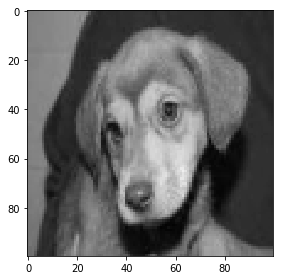

In [24]:
imshow( layer_output[0][0,:,:,0] )

## Layer 1: stack of convolutions

4 3x3 convolutional kernals, resulting in 4 channels.

In [25]:
layer_output[1].shape

TensorShape([1, 98, 98, 4])

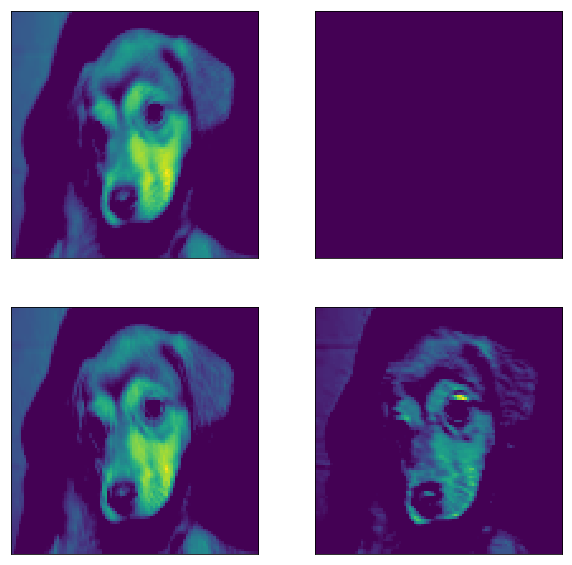

In [26]:
nrows, ncols = 2,2
fig, axs = plt.subplots(nrows,ncols,  figsize=(10,10))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        ax.imshow( layer_output[1][0,:,:,i*ncols+j] )
        ax.set_xticks([])
        ax.set_yticks([])

This layer has learned four 3x3 kernals. We can fetch them using the `get_weights` method of the layer:

In [37]:
W, b = model.layers[0].get_weights()
W.shape

(3, 3, 1, 4)

Note the shape of the kernal `ndarray` is `(kernal_width, kernal_height, input_channels, n_kernals)`. Because the input is a black-and-white image, the number of input channels is `1`.

## Layer 2: max pool

In [38]:
layer_output[2].shape

TensorShape([1, 49, 49, 4])

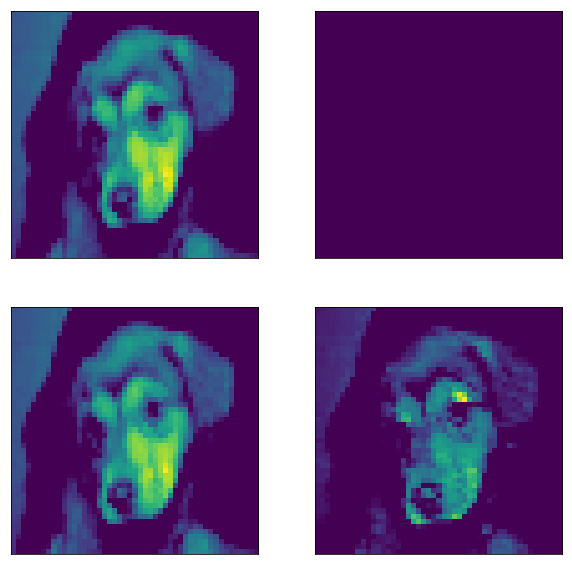

In [39]:
nrows, ncols = 2,2
fig, axs = plt.subplots(nrows,ncols,  figsize=(10,10))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        ax.imshow( layer_output[2][0,:,:,i*ncols+j] )
        ax.set_xticks([])
        ax.set_yticks([])

## Layer 3: Dropout

This layer instructs the trainer to turn off some fraction of neurons every training pass. However it has no effect on a forward pass.

In [40]:
layer_output[3].shape

TensorShape([1, 49, 49, 4])

## Layer 4: stack of 9 3x3 convolutions

Because there are 9 convolutional kernals in this layer, there will be 9 channels of output

In [41]:
layer_output[4].shape

TensorShape([1, 47, 47, 9])

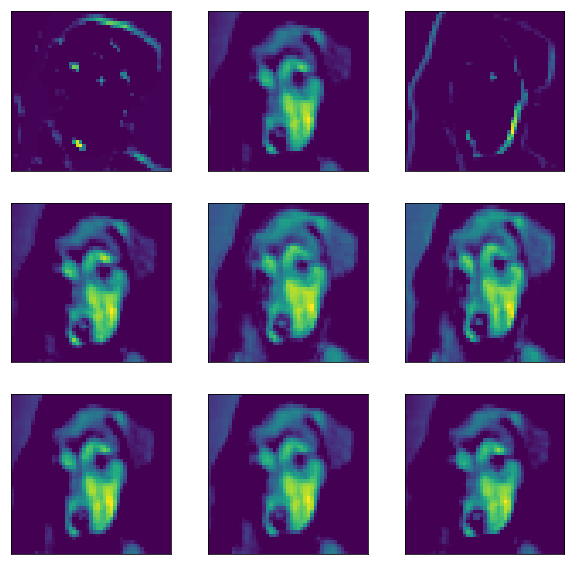

In [42]:
nrows, ncols = 3,3
fig, axs = plt.subplots(nrows,ncols,  figsize=(10,10))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        ax.imshow( layer_output[4][0,:,:,i*ncols+j] )
        ax.set_xticks([])
        ax.set_yticks([])

If we fetch the convolutional kernals in this layer, we see that each 3x3 kernal is actually an `ndarray` with shape `(3,3,4)`, because it is operating on an 4-channel input. The input has 4 channels because the preceding layer output `4` channels - one corresponding to each kernal in the first convolutional yaer.

In [44]:
W, b = model.layers[3].get_weights()

W.shape

(3, 3, 4, 9)

Here's one kernel.

In [69]:
first_kernel = W[:,:,:,0]
first_kernel

array([[[-0.2569661 ,  0.15718417, -0.14314394,  0.06136535],
        [-0.47072345,  0.14599602, -0.44763348, -0.68230754],
        [-0.44550958, -0.0266472 , -0.47396922, -0.62404984]],

       [[ 0.06318704, -0.10560441, -0.06458967,  0.28458834],
        [-0.16050474, -0.19178212, -0.1253393 , -0.39203975],
        [-0.26469147,  0.13105075, -0.33025825, -0.49085468]],

       [[ 0.4057421 ,  0.18458757,  0.33281052,  0.34989986],
        [ 0.05265709,  0.12402451,  0.22293021,  0.13257678],
        [ 0.0130937 , -0.01176574,  0.30561128, -0.01082968]]],
      dtype=float32)

If we grab a 3-pixel-wide by 3-pixel-tall chunk of the upper-lefthand corner of the preceding layer, grabbing every channel at once:

In [70]:
layer_3_chunk = layer_output[3].numpy()[0, 0:3, 0:3, :]
layer_3_chunk

array([[[0.12300709, 0.        , 0.1321168 , 0.01824547],
        [0.12950152, 0.        , 0.14061701, 0.0218752 ],
        [0.13597298, 0.        , 0.14644885, 0.02639383]],

       [[0.1270197 , 0.        , 0.13666934, 0.02086022],
        [0.13202816, 0.        , 0.14206594, 0.02366395],
        [0.13597417, 0.        , 0.14645088, 0.02639627]],

       [[0.12957859, 0.        , 0.13968045, 0.02382283],
        [0.13406801, 0.        , 0.14361459, 0.02408297],
        [0.13659725, 0.        , 0.14663696, 0.02566338]]], dtype=float32)

Note the kernel and a cross-sectional-chunk of the preceding layer have the same shape.

In [72]:
first_kernel.shape, layer_3_chunk.shape

((3, 3, 4), (3, 3, 4))

Thus they can be pairwise-multiplied and summed. This is essentially the convolution function, slid across every position in the preceding layer's output.

In [75]:
(first_kernel * layer_3_chunk).sum()

-0.27915415

## Layer 5: maxpool


In [79]:
layer_output[5].shape

TensorShape([1, 23, 23, 9])

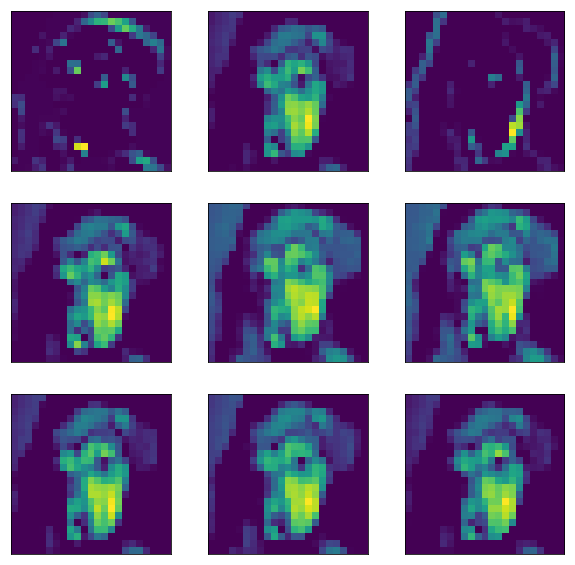

In [80]:
nrows, ncols = 3,3
fig, axs = plt.subplots(nrows,ncols,  figsize=(10,10))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        ax.imshow( layer_output[5][0,:,:,i*ncols+j] )
        ax.set_xticks([])
        ax.set_yticks([])

## Layer 7: stack of 4 3x3 convolutions

In [109]:
layer_output[7].shape

TensorShape([1, 21, 21, 4])

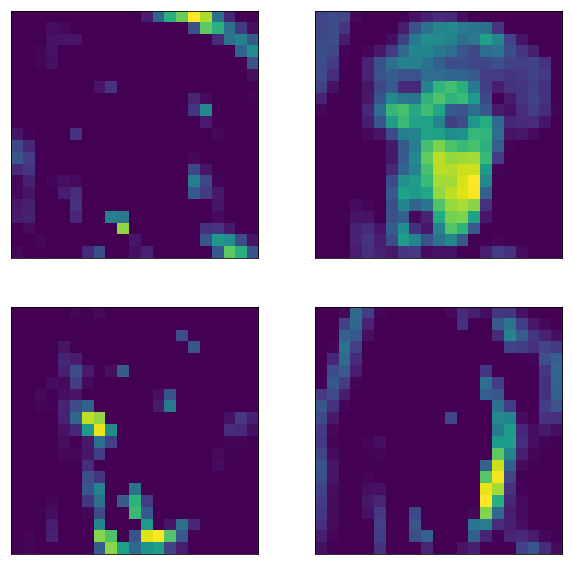

In [111]:
nrows, ncols = 2,2
fig, axs = plt.subplots(nrows,ncols,  figsize=(10,10))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        ax.imshow( layer_output[7][0,:,:,i*ncols+j] )
        ax.set_xticks([])
        ax.set_yticks([])

Once again we have four convolutional kernals, which span a 3x3 section of images across, in this case, **9** input channels.

In [112]:
W, b = model.layers[6].get_weights()

W.shape

(3, 3, 9, 4)

Classical image analysis involves
1. Applying filters to an image
2. Flattening the resulting image to produce a sample vector $\vec{x}_i$ of features for that image.
3. Using classical machine learning techniques on the resulting featurization.

Convolutional neural networks are divided into two sections:

1. A "filter" section, which outputs a fancy output "image" filled with pixels that turn out to be good discriminators. This filter is learned.
2. A "classical machine learning" step, in the form of single- or multi-layer perceptron.

The convolution/maxpool steps are the "filter" section. The output "image" is basically all the channels output from the last convolution step glued together:

In [146]:
foo = layer_output[7].numpy()
ul = foo[0,:,:,0]
ur = foo[0,:,:,1]
ll = foo[0,:,:,2]
lr = foo[0,:,:,3]
filter_output = np.vstack([np.hstack([ul,ur]), np.hstack([ll, lr])])
filter_output.shape

(42, 42)

Text(0.5, 1.0, 'Output of the `filter` learned by the convnet')

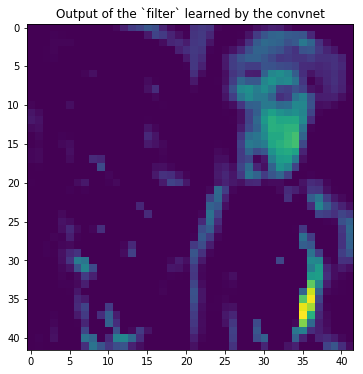

In [147]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow( filter_output )
ax.set_title("Output of the `filter` learned by the convnet")

## Layer 8: flatten

The 8th layer simply flattens the last convolution layer. The resulting matrix has shape `(n_samples, n_features)`.

In [148]:
layer_output[8].shape

TensorShape([1, 1764])

In principle one could simply take this matrix and train a random forest, or any other supervised model. Traditionally, we complete the model with a multiplayer perceptron.

## Layer 9: densely connected neural layer

This hidden perceptron layer has 8 neurons, each with 1764 connections to every pixel in the previous layer.

In [192]:
W, b = model.layers[8].get_weights()
W.shape

(1764, 8)

To find the activation of the 0th neuron, for example, get the weight of each connection:

In [193]:
neuron0_weights = W[:,0]
neuron0_weights

array([ 0.07787755, -0.10801972, -0.07755686, ..., -0.13650863,
       -0.28058264, -0.14251898], dtype=float32)

Take the dot product against all the pixels output from the "image filter" stage (flattened, of course). A bias terms was also learned by the convnet.

In [194]:
neuron0_activation = neuron0_weights.dot( layer_output[8][0] ) + b[0]
neuron0_activation

-2.634412

The activation is the excitation of the neuron passed through an activation function:

In [195]:
activations.relu( neuron0_activation ).numpy()

0.0

To do this all at once, just apply the weights and biases via this handy equation:

$$\phi( X W + b )$$

where $\phi$ is the activation function.

In [196]:
activations.relu( layer_output[8].numpy() @ W + b ).numpy()

array([[ 0.      ,  0.      ,  0.      ,  0.      , 17.357916,  0.      ,
         0.      ,  0.      ]], dtype=float32)

In doing that we've reproduced the work of the densely connected layer:

In [200]:
layer_output[9].numpy()

array([[ 0.      ,  0.      ,  0.      ,  0.      , 17.357908,  0.      ,
         0.      ,  0.      ]], dtype=float32)

## Layer 10: logistic regression

The last layer is simply logistic regression:

In [201]:
W, b = model.layers[9].get_weights()

In [208]:
W.flatten(), b[0]

(array([ 0.6081582 ,  0.3509726 , -0.6765918 , -0.55358076, -0.24426915,
         0.48285958, -0.5187643 ,  0.53817123], dtype=float32), 0.4467189)

It's simply $sigmoid( XW+b )$

In [211]:
activations.sigmoid( W.flatten().dot( layer_output[9].numpy().flatten() ) + b.flatten() )

<tf.Tensor: id=36700, shape=(1,), dtype=float32, numpy=array([0.0220255], dtype=float32)>

This is the output of the final layer:

In [216]:
layer_output[10].numpy()

array([[0.0220255]], dtype=float32)

It seems we did ever so slightly better than the class imbalance. There's definitely a chance we picked up a few correct classifications just by chance. Generally, much larger convnets (deeper and more kernels at each layer) are needed to perform well at image recognition tasks.

In [224]:
yhat = (model.predict( X_test ).flatten()>0.5).astype(int)

In [225]:
(labels_test == yhat).mean()

0.6

In [226]:
1-labels_test.mean()

0.5375